## 詞庫手法

In [1]:
import nltk

In [2]:
nltk.download('wordnet')

[nltk_data] Error loading wordnet: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


False

In [5]:
from nltk.corpus import wordnet as wn
wn.synsets('motorcar')

[Synset('car.n.01')]

In [6]:
wn.synsets('trunk')

[Synset('trunk.n.01'),
 Synset('trunk.n.02'),
 Synset('torso.n.01'),
 Synset('luggage_compartment.n.01'),
 Synset('proboscis.n.02')]

In [7]:
wn.synset('car.n.01').lemma_names()

['car', 'auto', 'automobile', 'machine', 'motorcar']

## 計數手法

In [8]:
s = 'you say goodbye and I say hello. '

In [20]:
import numpy as np
text = s
text = text.lower()
words = text.split()
words_to_id = {}
id_to_words = {}
for idx, word in enumerate(words):
    words_to_id[word] = idx
    id_to_words[idx] = word
words_to_id
id_to_words

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'say', 6: 'hello.'}

In [16]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    corpus = np.array([word_to_id[w] for w in words])
    return corpus, word_to_id, id_to_word

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)


In [17]:
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [18]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [19]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [23]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
    return co_matrix

In [24]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)

In [26]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [25]:
C = create_co_matrix(corpus, vocab_size)
C

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

In [28]:
def cos_similarity(x, y, eps=1e-8):
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)


In [29]:
c0 = C[word_to_id['you']]
c0

array([0, 1, 0, 0, 0, 0, 0], dtype=int32)

In [30]:
c1 = C[word_to_id['i']]
c1

array([0, 1, 0, 1, 0, 0, 0], dtype=int32)

In [31]:
cos_similarity(c0, c1)

0.7071067691154799

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
cs = cosine_similarity(C)

In [34]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    
    # 1. 列出Query
    if query not in word_to_id:
        print('%s is not found' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    # 2. 計算Cosine Similarity
    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
        
    # 3. 從cosine similarity 由高到低列出數值結果
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

In [36]:
most_similar('you', word_to_id, id_to_word, C)


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


In [41]:
from sklearn.metrics.pairwise import cosine_distances
cs = cosine_distances(C)

In [48]:
for idx in cs[0].argsort()[1:6]:
    print(id_to_word[idx], cs[0][idx])

goodbye 0.29289321881345254
i 0.29289321881345254
hello 0.29289321881345254
say 1.0
and 1.0


In [49]:
def ppmi(C, verbose=False, eps = 1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M

In [51]:
W = ppmi(C)

In [52]:
W

array([[0.       , 1.8073549, 0.       , 0.       , 0.       , 0.       ,
        0.       ],
       [1.8073549, 0.       , 0.8073549, 0.       , 0.8073549, 0.8073549,
        0.       ],
       [0.       , 0.8073549, 0.       , 1.8073549, 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 1.8073549, 0.       , 1.8073549, 0.       ,
        0.       ],
       [0.       , 0.8073549, 0.       , 1.8073549, 0.       , 0.       ,
        0.       ],
       [0.       , 0.8073549, 0.       , 0.       , 0.       , 0.       ,
        2.807355 ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 2.807355 ,
        0.       ]], dtype=float32)

In [54]:
# SVD
U, S, V = np.linalg.svd(W)

In [55]:
W.shape

(7, 7)

In [58]:
U.shape, S.shape, V.shape

((7, 7), (7,), (7, 7))

Populating the interactive namespace from numpy and matplotlib


/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


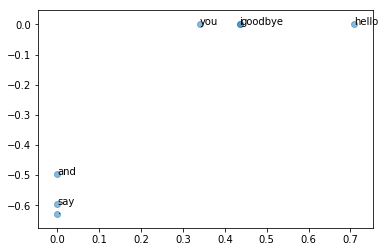

In [59]:
%pylab inline
from matplotlib import pyplot as plt
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

## Neural Network

In [60]:
import numpy as np
house_X = np.array([30, 300, 10])

In [61]:
house_X

array([ 30, 300,  10])

In [64]:
house_X.shape

(3,)

In [62]:
house_W = np.array([[70], [-1], [-6]])

In [65]:
house_W

array([[70],
       [-1],
       [-6]])

In [66]:
house_W.shape

(3, 1)

In [67]:
np.dot(house_X, house_W)

array([1740])

In [68]:
def sigmoid_function(x):
    return 1/ (1 + np.exp(-x))


In [69]:
import numpy as np
X = np.array([1,2]) # (2)
W = np.array([[1,3,5],[2,4,6]]) # (2 , 3)
B = np.array([1,2,3])

Y = np.dot(X,W) + B# (3)

A = sigmoid_function(Y)
A

array([0.99752738, 0.99999774, 1.        ])

In [70]:
W1 = np.array([[1,2],[3,4],[5,6]]) # (3 , 2)
B1 = np.array([1,2])
Y1 = np.dot(A, W1) + B1
Y1 # (2)

array([ 9.99752059, 13.9950457 ])

In [72]:
c = np.array([[1, 0, 0, 0, 0, 0, 0]])
c

array([[1, 0, 0, 0, 0, 0, 0]])

In [73]:
W = np.random.randn(7, 3)
W

array([[ 0.22411671, -0.42337363,  0.30125317],
       [-0.90864496,  2.42151804, -0.98993779],
       [-0.16548563, -1.11887548,  0.45773035],
       [-0.41049857, -2.28458649, -0.8766367 ],
       [ 0.28536285, -1.97796828,  0.06823124],
       [-0.32297675, -0.96620916, -0.61939916],
       [ 0.32924283, -0.20302245, -1.1959254 ]])

In [74]:
h = np.dot(c,W)
print(h)

[[ 0.22411671 -0.42337363  0.30125317]]


In [75]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx

In [76]:
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

W_in  = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
print(s)

[[-0.690989   -2.35342418 -0.9818263   1.4413382  -1.36603427  0.44567065
   0.58484311]]


In [77]:
def softmax_function(x):
    return np.exp(x) / np.sum(np.exp(x))

softmax_function(numpy.array([-1,1,2]))

array([0.03511903, 0.25949646, 0.70538451])

In [78]:
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
    return np.array(contexts), np.array(target)

In [79]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
contexts, target = create_contexts_target(corpus, 1)
print(contexts, target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]] [1 2 3 4 1 5]


In [80]:
def convert_one_hot(corpus, vocab_size):
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1
    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1
    return one_hot

In [81]:
vocab_size = len(word_to_id)
vocab_size

7

In [82]:
contexts, target = create_contexts_target(corpus, 1)

In [84]:
contexts

array([[0, 2],
       [1, 3],
       [2, 4],
       [3, 1],
       [4, 5],
       [1, 6]])

In [85]:
target

array([1, 2, 3, 4, 1, 5])

In [86]:
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [88]:
contexts.shape

(6, 2, 7)

In [89]:
target.shape

(6, 7)

In [90]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx


class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx


class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out

    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx


class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx


class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None 
        self.t = None 

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx


class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None

In [91]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

In [92]:
vocab_size = len(word_to_id)
hidden_size = 5
model = SimpleCBOW(vocab_size, hidden_size)

In [95]:
class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

In [96]:
optimizer = Adam()

In [97]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [98]:
def remove_duplicate(params, grads):
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                if params[i] is params[j]:
                    grads[i] += grads[j]  
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

In [101]:
class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
       
            idx = numpy.random.permutation(numpy.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

              
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | loss %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()

In [102]:
trainer = Trainer(model, optimizer)

In [103]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

In [114]:
window_size = 1
batch_size = 3
max_epoch = 10
trainer.fit(contexts, target, max_epoch, batch_size)

| epoch 2621 |  iter 1 / 2 | time 0[s] | loss 0.24
| epoch 2622 |  iter 1 / 2 | time 0[s] | loss 0.24
| epoch 2623 |  iter 1 / 2 | time 0[s] | loss 0.24
| epoch 2624 |  iter 1 / 2 | time 0[s] | loss 0.36
| epoch 2625 |  iter 1 / 2 | time 0[s] | loss 0.01
| epoch 2626 |  iter 1 / 2 | time 0[s] | loss 0.47
| epoch 2627 |  iter 1 / 2 | time 0[s] | loss 0.13
| epoch 2628 |  iter 1 / 2 | time 0[s] | loss 0.13
| epoch 2629 |  iter 1 / 2 | time 0[s] | loss 0.36
| epoch 2630 |  iter 1 / 2 | time 0[s] | loss 0.24


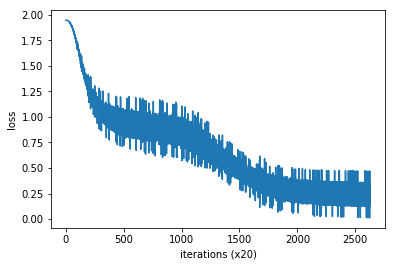

In [116]:

trainer.plot()

In [121]:
model.word_vecs.shape

(7, 5)

In [117]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-3.0197244  -0.66500604  0.9788965  -2.5115094  -2.4862497 ]
say [ 1.9274521  1.0592844 -1.6078502  1.6223705  1.2155228]
goodbye [ 0.62380654 -2.0771635   1.9081205  -0.01204651 -0.02666894]
and [-0.05161366  3.0025125   1.2629162   2.173613    2.9995368 ]
i [ 0.6256028  -2.063149    1.9175583  -0.01632257 -0.02905285]
hello [-3.0255537 -0.6577454  0.9786197 -2.4892027 -2.4912066]
. [ 2.7054768  -1.4704615  -3.0654788  -0.09320928 -1.3341477 ]


In [122]:
word_to_id['you']


0

In [123]:
word_vecs[0]


array([-3.0197244 , -0.66500604,  0.9788965 , -2.5115094 , -2.4862497 ],
      dtype=float32)

In [126]:
for i in range(7):
    cs = cosine_distances([word_vecs[0], word_vecs[i]])
    print(id_to_word[i],cs[0][1])

you 0.0
say 1.9328661
goodbye 0.8944926
and 1.5714283
i 0.8935633
hello 1.2218952e-05
. 1.3045679
